In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split

from zipfile import ZipFile
import os
import sys

# Load modules from the lib directory
sys.path.insert(0, "../lib")
from resnet import load_resnet, ResNet18
from lossFunctions import get_custom_cross_entropy, l1_loss

In [ ]:
if not os.path.exists("./drive"):
    drive.mount('/content/drive')

if not os.path.exists("../data"):
    os.mkdir("../data")

# loading the temp.zip and creating a zip object
with ZipFile("./drive/MyDrive/train_data.zip", 'r') as zip_object:

    # Extracting all the members of the zip 
    # into a specific location.
    zip_object.extractall(path="../data")


In [ ]:
class LabelCleaner(tf.keras.Model):

    def __init__(self, CNN: tf.keras.Model):
        super(LabelCleaner, self).__init__()

        # Base CNN model
        self.CNN = CNN
        
        # Fully connected dense layers
        self.fc_1 = tf.keras.layers.Dense(units = 20, use_bias=False)
        self.fc_2 = tf.keras.layers.Dense(units = 256)
        self.fc_3 = tf.keras.layers.Dense(units = 256, use_bias=False, activation = "relu")
        self.fc_4 = tf.keras.layers.Dense(units = 10, use_bias=False,)
        
        # Batch Normalization layers
        self.bn_1 = tf.keras.layers.BatchNormalization()
        self.bn_2 = tf.keras.layers.BatchNormalization()
        self.bn_3 = tf.keras.layers.BatchNormalization()

    def call(self, inputs):
        img, y = inputs

        # Get the CNN output
        x = self.CNN(img)

        # Embed the output of the CNN to the noisy labels
        x = tf.concat([x, y], axis = 1)
        
        x = self.fc_1(x)    # Linear followed by batch normalization
        x = self.bn_1(x)

        x = self.fc_2(x)    # Linear followed by batch normalization
        x = self.bn_2(x)

        x = self.fc_3(x)    # ReLU

        x = self.fc_4(x)    # Linear followed by batch normalization
        x = self.bn_3(x)

        x = x + y           # Residual connection
        x = tf.minimum(x, 1)
        x = tf.maximum(x, 0)

        return x

In [ ]:
# [DO NOT MODIFY THIS CELL]

n_images: int = 50_000
n_noisy: int = 40_000
n_clean: int = n_images - n_noisy

images : np.ndarray = np.empty((n_images, 32, 32, 3), dtype=np.float32)

# Load the data
for i in range(n_images):
    image_path = f"../data/images/{i+1:05d}.png"
    images[i,:,:,:] = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

In [ ]:
cnn_1 = load_resnet(shape = (32, 32, 3))
cnn_1.trainable = False

In [ ]:
test_ratio: float = 0.2
train_size: float = n_images - (n_clean * test_ratio)
clean_noisy_ratio: float = 1 / 9
train_clean_size: int = int(np.floor(train_size * clean_noisy_ratio))
val_clean_size: int = int(np.floor((n_clean * (1 - test_ratio)) - train_clean_size))
test_clean_size: int = n_clean - train_clean_size - val_clean_size

IMG_SIZE: int = 32
IMG_SHAPE: tuple = (IMG_SIZE, IMG_SIZE, 3)

BATCH_SIZE: int = 128

In [ ]:
images_normalized = tf.cast(images, dtype = tf.float32) / 255.0
clean_labels_one_hot = tf.one_hot(clean_labels, depth = 10)
noisy_labels_one_hot = tf.one_hot(noisy_labels, depth = 10)

In [ ]:
x_clean = images_normalized[:n_clean]
y_clean = clean_labels_one_hot
x_noisy = images_normalized[n_clean:]
y_noisy = noisy_labels_one_hot

In [ ]:
def build_base_cnn(cnn:tf.keras.Model) -> tf.keras.Model:
    """
    Build the base CNN model.

    `return`
        The base CNN model.
    """
    model = tf.keras.models.Sequential([
        cnn,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10)
    ])
    return model

In [ ]:
x_clean_train_full, x_clean_test, y_clean_train_full, y_clean_test = train_test_split(x_clean.numpy(), y_clean.numpy(), test_size = 0.1) 

In [ ]:
x_clean_train, x_clean_val, y_clean_train, y_clean_val = train_test_split(x_clean_train_full, y_clean_train_full, test_size = 0.2) 

In [ ]:
x_clean_train_size = len(x_clean_train)
x_clean_val_size = len(x_clean_val)
x_clean_test_size = len(x_clean_test)

In [ ]:
V = tf.data.Dataset.from_tensor_slices((
    (
        x_clean_train_full,
        noisy_labels_one_hot[:len(y_clean_train_full)]
    ),
    y_clean_train_full
))
V_test = tf.data.Dataset.from_tensor_slices((
    (
        x_clean_test,
        noisy_labels_one_hot[x_clean_train_size + x_clean_val_size:10000]
    ),
    y_clean_test
)).batch(batch_size = BATCH_SIZE)

In [ ]:
V_train = V.take(x_clean_train_size).batch(batch_size = BATCH_SIZE)
V_val = V.skip(x_clean_train_size).take(x_clean_val_size).batch(batch_size = BATCH_SIZE)

In [ ]:
del V

In [ ]:
len(V_train), len(V_val), len(V_test)

(57, 15, 8)

In [ ]:
aug = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(x_clean_train)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True)

In [ ]:
# Model 1
cnn_1 = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), 
                        strides=1, padding='same',
                        input_shape=(32,32,3), use_bias=True), 
    # keras.layers.BatchNormalization(), 
    tf.keras.layers.Activation('relu'), 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid'), 
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), 
                       strides=1, padding='same', use_bias=True), 
    # keras.layers.BatchNormalization(), 
    tf.keras.layers.Activation('relu'), 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid'), 
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), 
                       strides=1, padding='same', use_bias=True), 
    tf.keras.layers.Activation('relu'), 
    # tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid'), 
    # tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.GlobalAvgPool2D(),

    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64, use_bias=False), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'), 
    tf.keras.layers.Dense(10, activation='softmax') 
]) 

In [ ]:
cnn_1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ["accuracy"]
)

In [ ]:
STEPS = len(x_clean_train) / 256

In [ ]:
cnn_1.fit(
    aug.flow(x_clean_train, y_clean_train, batch_size = 256),
    steps_per_epoch=STEPS,
    batch_size = 256,
    epochs = 100,
    validation_data = (x_clean_val, y_clean_val),
    callbacks = [es]
)

Epoch 1/100
28/28 [==============================] - 12s 128ms/step - loss: 2.0466 - accuracy: 0.2549 - val_loss: 2.2651 - val_accuracy: 0.1044
Epoch 2/100
28/28 [==============================] - 3s 119ms/step - loss: 1.8072 - accuracy: 0.3401 - val_loss: 2.2202 - val_accuracy: 0.2611
Epoch 3/100
28/28 [==============================] - 3s 123ms/step - loss: 1.6811 - accuracy: 0.3832 - val_loss: 2.1917 - val_accuracy: 0.2439
Epoch 4/100
28/28 [==============================] - 3s 117ms/step - loss: 1.5968 - accuracy: 0.4131 - val_loss: 2.1456 - val_accuracy: 0.2689
Epoch 5/100
28/28 [==============================] - 3s 118ms/step - loss: 1.5397 - accuracy: 0.4367 - val_loss: 2.0894 - val_accuracy: 0.3344
Epoch 6/100
28/28 [==============================] - 3s 121ms/step - loss: 1.4651 - accuracy: 0.4642 - val_loss: 2.0440 - val_accuracy: 0.4561
Epoch 7/100
28/28 [==============================] - 3s 119ms/step - loss: 1.4294 - accuracy: 0.4821 - val_loss: 1.9829 - val_accuracy: 0.448

In [ ]:
cnn_1.evaluate(x_clean_test, y_clean_test)

32/32 [==============================] - 0s 10ms/step - loss: 1.0284 - accuracy: 0.6650


[1.028435468673706, 0.6650000214576721]

In [ ]:
cnn_1 = load_resnet(10, (32, 32, 3))

In [ ]:
# cnn_1 = build_base_cnn()
cnn_1.trainable = False
cleaner = LabelCleaner(cnn_1)

cleaner.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = l1_loss,
    metrics = ['accuracy']
)

In [ ]:
cleaner.fit(
    V_train,
    epochs = 60,
    validation_data = V_val,
    callbacks = [es]
)

Epoch 1/60
57/57 [==============================] - 11s 31ms/step - loss: 155.7399 - accuracy: 0.5844 - val_loss: 179.0515 - val_accuracy: 0.3311
Epoch 2/60
57/57 [==============================] - 1s 14ms/step - loss: 93.4176 - accuracy: 0.6681 - val_loss: 151.9339 - val_accuracy: 0.4689
Epoch 3/60
57/57 [==============================] - 1s 14ms/step - loss: 87.9392 - accuracy: 0.6685 - val_loss: 117.9284 - val_accuracy: 0.6467
Epoch 4/60
57/57 [==============================] - 1s 14ms/step - loss: 78.8656 - accuracy: 0.6978 - val_loss: 92.3142 - val_accuracy: 0.6894
Epoch 5/60
57/57 [==============================] - 1s 14ms/step - loss: 70.8778 - accuracy: 0.7243 - val_loss: 78.8839 - val_accuracy: 0.7078
Epoch 6/60
57/57 [==============================] - 1s 14ms/step - loss: 69.7462 - accuracy: 0.7261 - val_loss: 73.0319 - val_accuracy: 0.7144
Epoch 7/60
57/57 [==============================] - 1s 14ms/step - loss: 68.5127 - accuracy: 0.7329 - val_loss: 70.9509 - val_accuracy: 0

In [ ]:
cleaner.evaluate(V_test)
cleaner.trainable = False

8/8 [==============================] - 1s 72ms/step - loss: 19.9720 - accuracy: 0.9200


In [ ]:
# cleaned_labels = cleaner.predict([x_noisy, y_noisy[n_clean:]])


In [ ]:
v_train_full = tf.cast(y_clean_train, dtype = tf.float32)
c_train_full = tf.constant(
    cleaner.predict([
        images_normalized[n_clean:],
        y_noisy[n_clean:]
    ]), 
    dtype = tf.float32
)

features = tf.concat([x_clean_train, x_noisy], 0)
target = tf.concat([v_train_full, c_train_full], 0)

1250/1250 [==============================] - 9s 6ms/step


In [ ]:
c_train_full.numpy()[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
train_ds_2 = tf.data.Dataset.from_tensor_slices((
    features, target
)).batch(BATCH_SIZE)

val_ds_2 = tf.data.Dataset.from_tensor_slices((
    x_clean_val,
    y_clean_val
)).batch(BATCH_SIZE)

In [ ]:
def build_image_classifier(cnn: tf.keras.Model) -> tf.keras.Model:
    """
    Build a new model that takes images as input and outputs class probabilities.

    Parameters:
    -----------

    `cnn: tf.keras.Model` 
        The base CNN model to use.

    `return`
        The new model.
    """
    return tf.keras.Sequential([
        cnn,
        tf.keras.layers.Dense(units = 64),
        tf.keras.layers.Dense(units = 10, activation = "sigmoid")
    ])

In [ ]:
image_classifier = build_image_classifier(cnn_1)
image_classifier.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=['accuracy']
)

In [ ]:
image_classifier.fit(
    train_ds_2,
    epochs = 60,
    validation_data = (val_ds_2)
)

Epoch 1/60
369/369 [==============================] - 6s 12ms/step - loss: 0.2235 - accuracy: 0.9363 - val_loss: 0.7584 - val_accuracy: 0.9022
Epoch 2/60
369/369 [==============================] - 4s 10ms/step - loss: 0.2801 - accuracy: 0.9237 - val_loss: 1.0315 - val_accuracy: 0.8967
Epoch 3/60
369/369 [==============================] - 4s 11ms/step - loss: 0.4625 - accuracy: 0.9063 - val_loss: 2.3288 - val_accuracy: 0.7811
Epoch 4/60
369/369 [==============================] - 4s 11ms/step - loss: 0.7144 - accuracy: 0.9041 - val_loss: 1.5905 - val_accuracy: 0.8994
Epoch 5/60
369/369 [==============================] - 4s 10ms/step - loss: 0.7956 - accuracy: 0.8966 - val_loss: 2.0070 - val_accuracy: 0.9000
Epoch 6/60
369/369 [==============================] - 4s 10ms/step - loss: 0.8689 - accuracy: 0.8995 - val_loss: 2.2549 - val_accuracy: 0.8994
Epoch 7/60
369/369 [==============================] - 4s 10ms/step - loss: 1.1893 - accuracy: 0.8947 - val_loss: 2.6887 - val_accuracy: 0.8989

In [ ]:
image_classifier.evaluate(x_clean_test, y_clean_test)

32/32 [==============================] - 0s 11ms/step - loss: 11.6509 - accuracy: 0.8910


[11.650897979736328, 0.890999972820282]

In [ ]:
_, (x_test, y_test) = cifar_10 = tf.keras.datasets.cifar10.load_data()

In [ ]:
del _

In [ ]:
mapping = {m:(9 - m) for m in range(10)}

In [ ]:
mapping

{0: 9, 1: 8, 2: 7, 3: 6, 4: 5, 5: 4, 6: 3, 7: 2, 8: 1, 9: 0}

In [ ]:
def corrupt_labels(y):
    return mapping[y[0]]

In [ ]:
y_test_corrupted = np.array(list(map(corrupt_labels, y_test)))
y_test_corrupted = tf.one_hot(y_test_corrupted, depth = 10)

In [ ]:
tf.reduce_mean(tf.keras.metrics.categorical_accuracy(y_test_corrupted, tf.one_hot(y_test, depth = 10)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.1>

In [ ]:
x_test_normalized = x_test / 255.0

In [ ]:
preds = cleaner.predict([x_test_normalized, y_test_corrupted])

313/313 [==============================] - 2s 6ms/step


In [ ]:
tf.argmax(preds, 1)

<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([3, 8, 8, ..., 5, 1, 7])>

In [ ]:
# preds = image_classifier.predict(x_train_normalized)

1563/1563 [==============================] - 4s 2ms/step


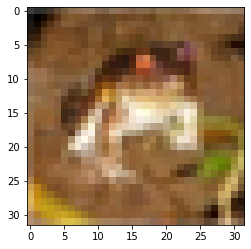

In [ ]:
plt.imshow(x_train_normalized[0])

In [ ]:
(preds == y_train).sum() / y_train.shape[0]


1.0